<a href="https://colab.research.google.com/github/fer3her/vision-con-IA/blob/main/Reto_%E2%80%9CCreaci%C3%B3n_del_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reto “Creación del dataset”**
Basándose en la propuesta realizada en el Artículo: Dataset para filtro de speckle y su Repositorio github para rescalizado, registro y recorte, realice este mismo procedimiento con las imágenes no filtradas para generar su dataset propio de imágenes de 512x512 en pares (SAR y Ground Truth).
Recuerde que el procedimiento es:
*Imágenes no filtradas

*   Imágenes no filtradas
*   Seleccionar una imagen no filtrada como base. Esta será la que se divide para generar la carpeta de imágenes con ruido (noisy).
*Hacer registro de todas respecto a la seleccionada en el paso anterior
*Fusionar todas las imágenes resultantes en una sola con una operación de media. Puede usar mediana si quiere para variar el ejercicio.
Recortar las imágenes, tanto la del paso b) como la resultante del paso d).
Puede usar sólo 5 imágenes, aunque en el artículo se hizo con 10.
Suministre enlace de drive, o repositorio donde haya creado el dataset con imágenes de 512x512 para poder visualizarlo.


In [ ]:
# Adaptado de https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/
import numpy as np
import imutils
import cv2

def align_image(image, template, maxFeatures=500, keepPercent=0.2, debug=False):
    # Convertir tanto la imagen de entrada como la plantilla a escala de grises
    imageGray = image.copy()
    templateGray = template.copy()

    # Usar ORB para detectar puntos clave y extraer características locales (binarias) invariantes
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)

    # Emparejar las características
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)

    # Ordenar las coincidencias por su distancia (a menor distancia, mayor similitud)
    matches = sorted(matches, key=lambda x: x.distance)

    # Conservar solo las mejores coincidencias
    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]

    # Visualizar los puntos clave emparejados si se activa el modo de depuración
    if debug:
        matchedVis = cv2.drawMatches(image, kpsA, template, kpsB, matches, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        cv2.imshow("Puntos clave emparejados", matchedVis)
        cv2.waitKey(0)

    # Asignar memoria para las coordenadas (x, y) de los puntos clave de las mejores coincidencias
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")

    # Recorrer las mejores coincidencias
    for (i, m) in enumerate(matches):
        # Indicar que los dos puntos clave en las respectivas imágenes se corresponden
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt

    # Calcular la matriz de homografía entre los dos conjuntos de puntos
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)

    # Usar la matriz de homografía para alinear las imágenes
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(image, H, (w, h))

    # Devolver la imagen alineada
    return aligned

# Ruta de la carpeta donde se encuentra la imagen
basepath = '/content/drive/MyDrive/Imagenes reto 3 parcial -20250404T162556Z-001/'
# Nombre y extensión de la imagen escalada
imgpath = 'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250312t065516-20250312t065541-058268-0733a0-002_scaled.tiff'

# Inicio
# Imagen de referencia escalada
imgtemplatepath = 'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250228t065516-20250228t065541-058093-072c89-002_scaled.tiff'
template = cv2.imread(basepath + imgtemplatepath, cv2.IMREAD_GRAYSCALE)  # Imagen de referencia

print("[INFO] Cargando imágenes...")
image = cv2.imread(basepath + imgpath, cv2.IMREAD_GRAYSCALE)  # Imagen a alinear
image = cv2.resize(image, (template.shape[1], template.shape[0]), interpolation=cv2.INTER_AREA)

# Alinear las imágenes
print("[INFO] Alineando imágenes...")
aligned = align_image(image, template, maxFeatures=500, debug=False)
aligned = cv2.resize(aligned, (template.shape[1], template.shape[0]), interpolation=cv2.INTER_AREA)

# Verificación de tamaño
print('Tamaño antes de la alineación: ', image.shape)
print('Tamaño después de la alineación: ', aligned.shape)

# Guardar la imagen alineada en disco
pathsplit = imgpath.split('.tiff')
imgpathregist = basepath + pathsplit[0] + '_registered.tiff'
cv2.imwrite(imgpathregist, aligned)

# Función para calcular el Error Cuadrático Medio (MSE)
def calculate_mse(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    return mse

# Imprimir MSE antes y después de la alineación
print('MSE antes de la alineación: ', calculate_mse(template, image))
print('MSE después de la alineación: ', calculate_mse(template, aligned))


[INFO] Cargando imágenes...
[INFO] Alineando imágenes...
Tamaño antes de la alineación:  (16660, 25736)
Tamaño después de la alineación:  (16660, 25736)
MSE antes de la alineación:  797.2679133885447
MSE después de la alineación:  685.1743540048907


In [6]:
# Adaptado de https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/
import numpy as np
import imutils
import cv2
import os

def align_image(image, template, maxFeatures=500, keepPercent=0.2, debug=False):
    # Convertir las imágenes a escala de grises
    imageGray = image.copy()
    templateGray = template.copy()

    # Detectar puntos clave con ORB
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)

    # Emparejar características
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)
    matches = sorted(matches, key=lambda x: x.distance)
    matches = matches[:int(len(matches) * keepPercent)]

    # Visualizar coincidencias si se activa debug
    if debug:
        matchedVis = cv2.drawMatches(image, kpsA, template, kpsB, matches, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        cv2.imshow("Matched Keypoints", matchedVis)
        cv2.waitKey(0)

    # Extraer coordenadas de los puntos clave emparejados
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")
    for (i, m) in enumerate(matches):
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt

    # Calcular la matriz de homografía y aplicar la transformación
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(image, H, (w, h))

    return aligned

def calculate_mse(img1, img2):
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    return mse

# Ruta base
basepath = '/content/drive/MyDrive/Imagenes reto 3 parcial -20250404T162556Z-001/'

# Imagen de referencia
imgtemplatepath = 'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250228t065516-20250228t065541-058093-072c89-002_scaled.tiff'
template = cv2.imread(os.path.join(basepath, imgtemplatepath), cv2.IMREAD_GRAYSCALE)

# Lista de imágenes a registrar
images_to_register = [
    'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250324t065541-20250324t065606-058443-073a8a-002_scaled.tiff',
    'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250312t065541-20250312t065606-058268-0733a0-002_scaled.tiff',
    'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250324t065516-20250324t065541-058443-073a8a-002_scaled.tiff',
    'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250312t065516-20250312t065541-058268-0733a0-002_scaled.tiff'
]

print("[INFO] Cargando imagen de referencia...")
print('Template shape:', template.shape)

# Procesar cada imagen
for imgpath in images_to_register:
    print(f"\n[INFO] Procesando: {imgpath}")
    image = cv2.imread(os.path.join(basepath, imgpath), cv2.IMREAD_GRAYSCALE)

    # Redimensionar imagen para que coincida con la de referencia
    image = cv2.resize(image, (template.shape[1], template.shape[0]), interpolation=cv2.INTER_AREA)

    print('Forma antes de alinear:', image.shape)
    print("[INFO] Alineando imagen...")
    aligned = align_image(image, template, maxFeatures=500, debug=False)
    aligned = cv2.resize(aligned, (template.shape[1], template.shape[0]), interpolation=cv2.INTER_AREA)

    print('Forma después de alinear:', aligned.shape)

    # Guardar imagen alineada
    filename_base = imgpath.replace('.tiff', '')
    output_path = os.path.join(basepath, f"{filename_base}_registered.tiff")
    cv2.imwrite(output_path, aligned)

    # Calcular errores
    mse_before = calculate_mse(template, image)
    mse_after = calculate_mse(template, aligned)
    print('MSE antes del registro:', mse_before)
    print('MSE después del registro:', mse_after)


[INFO] Cargando imagen de referencia...
Template shape: (16660, 25736)

[INFO] Procesando: Imagenes reto 3 parcial/s1a-iw-grd-vh-20250324t065541-20250324t065606-058443-073a8a-002_scaled.tiff
Forma antes de alinear: (16660, 25736)
[INFO] Alineando imagen...
Forma después de alinear: (16660, 25736)
MSE antes del registro: 2539.2310973861104
MSE después del registro: 8579.477438771592

[INFO] Procesando: Imagenes reto 3 parcial/s1a-iw-grd-vh-20250312t065541-20250312t065606-058268-0733a0-002_scaled.tiff
Forma antes de alinear: (16660, 25736)
[INFO] Alineando imagen...
Forma después de alinear: (16660, 25736)
MSE antes del registro: 2598.072940362032
MSE después del registro: 11089.475261427231

[INFO] Procesando: Imagenes reto 3 parcial/s1a-iw-grd-vh-20250324t065516-20250324t065541-058443-073a8a-002_scaled.tiff
Forma antes de alinear: (16660, 25736)
[INFO] Alineando imagen...
Forma después de alinear: (16660, 25736)
MSE antes del registro: 757.6736201264777
MSE después del registro: 718.02

In [8]:
import cv2
import numpy as np
basepath = '/content/drive/MyDrive/Imagenes reto 3 parcial -20250404T162556Z-001/' #Path of folder where the image is located

#List of images
img1path = 'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250228t065516-20250228t065541-058093-072c89-002_scaled.tiff' #Image not aligined (registered) because it was used as the reference to register the rest
img2path = 'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250324t065541-20250324t065606-058443-073a8a-002_scaled_registered.tiff'
img3path = 'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250312t065541-20250312t065606-058268-0733a0-002_scaled_registered.tiff'
img4path = 'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250324t065516-20250324t065541-058443-073a8a-002_scaled_registered.tiff'
img5path ='Imagenes reto 3 parcial/s1a-iw-grd-vh-20250312t065516-20250312t065541-058268-0733a0-002_scaled_registered.tiff'

pathlist = [basepath + img1path,
               basepath + img2path,
               basepath + img3path,
               basepath + img4path,
               basepath + img5path,
             ]

#print(rutaimglist[0])
img = cv2.imread(pathlist[0])  #Image load
height, width, depth = img.shape
imgacum = np.zeros((height, width), np.single)
imgscalar = 10.0 * np.ones((height, width), np.single)

for imgpath in pathlist:
    print(imgpath)
    img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)  # Image load
    img = img.astype(np.single)
    imgacum = cv2.add(imgacum, img)
avgGT = cv2.divide(imgacum, imgscalar)
avgGT = avgGT.astype(np.uint8)
cv2.imwrite(basepath + 'AverageGT.tiff', avgGT)

/content/drive/MyDrive/Imagenes reto 3 parcial -20250404T162556Z-001/Imagenes reto 3 parcial/s1a-iw-grd-vh-20250228t065516-20250228t065541-058093-072c89-002_scaled.tiff
/content/drive/MyDrive/Imagenes reto 3 parcial -20250404T162556Z-001/Imagenes reto 3 parcial/s1a-iw-grd-vh-20250324t065541-20250324t065606-058443-073a8a-002_scaled_registered.tiff
/content/drive/MyDrive/Imagenes reto 3 parcial -20250404T162556Z-001/Imagenes reto 3 parcial/s1a-iw-grd-vh-20250312t065541-20250312t065606-058268-0733a0-002_scaled_registered.tiff
/content/drive/MyDrive/Imagenes reto 3 parcial -20250404T162556Z-001/Imagenes reto 3 parcial/s1a-iw-grd-vh-20250324t065516-20250324t065541-058443-073a8a-002_scaled_registered.tiff
/content/drive/MyDrive/Imagenes reto 3 parcial -20250404T162556Z-001/Imagenes reto 3 parcial/s1a-iw-grd-vh-20250312t065516-20250312t065541-058268-0733a0-002_scaled_registered.tiff


True

[INFO] Bloque 1 guardado.
[INFO] Bloque 2 guardado.
[INFO] Bloque 3 guardado.
[INFO] Bloque 4 guardado.
[INFO] Bloque 5 guardado.
[INFO] Bloque 6 guardado.
[INFO] Bloque 7 guardado.
[INFO] Bloque 8 guardado.
[INFO] Bloque 9 guardado.
[INFO] Bloque 10 guardado.
[INFO] Bloque 11 guardado.
[INFO] Bloque 12 guardado.
[INFO] Bloque 13 guardado.
[INFO] Bloque 14 guardado.
[INFO] Bloque 15 guardado.
[INFO] Bloque 16 guardado.
[INFO] Bloque 17 guardado.
[INFO] Bloque 18 guardado.
[INFO] Bloque 19 guardado.
[INFO] Bloque 20 guardado.
[INFO] Bloque 21 guardado.
[INFO] Bloque 22 guardado.
[INFO] Bloque 23 guardado.
[INFO] Bloque 24 guardado.
[INFO] Bloque 25 guardado.
[INFO] Bloque 26 guardado.
[INFO] Bloque 27 guardado.
[INFO] Bloque 28 guardado.
[INFO] Bloque 29 guardado.
[INFO] Bloque 30 guardado.
[INFO] Bloque 31 guardado.
[INFO] Bloque 32 guardado.
[INFO] Bloque 33 guardado.
[INFO] Bloque 34 guardado.
[INFO] Bloque 35 guardado.
[INFO] Bloque 36 guardado.
[INFO] Bloque 37 guardado.
[INFO] Blo

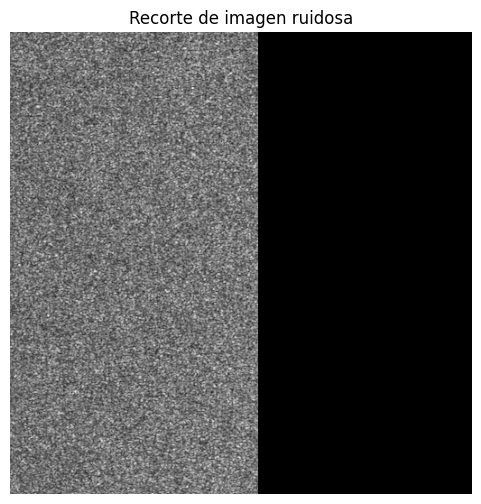

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Ruta base en Google Drive
basepath = '/content/drive/MyDrive/Imagenes reto 3 parcial -20250404T162556Z-001/'

# Rutas relativas de las imágenes
noisypath = 'Imagenes reto 3 parcial/s1a-iw-grd-vh-20250228t065516-20250228t065541-058093-072c89-002_scaled.tiff'
GTpath = 'AverageGT.tiff'

# Cargar imágenes (modo sin cambios por si tienen más de 8 bits)
imgnoisy = cv2.imread(os.path.join(basepath, noisypath), cv2.IMREAD_UNCHANGED)
imgGT = cv2.imread(os.path.join(basepath, GTpath), cv2.IMREAD_UNCHANGED)

# Verificación de carga
if imgnoisy is None:
    print("[ERROR] No se pudo cargar la imagen ruidosa.")
    exit()
if imgGT is None:
    print("[ERROR] No se pudo cargar la imagen Ground Truth.")
    exit()

# Parámetros
height, width = imgnoisy.shape[:2]
size = 512
step = 512
counter = 0

# Crear carpetas de salida si no existen
noisy_dir = os.path.join(basepath, 'Noisy')
gt_dir = os.path.join(basepath, 'Gtruth')
os.makedirs(noisy_dir, exist_ok=True)
os.makedirs(gt_dir, exist_ok=True)

# Recortar imágenes en bloques de 512x512
for i in range(0, height - size + 1, step):
    for j in range(0, width - size + 1, step):
        # Recorte de imagen ruidosa
        name_noisy = os.path.join(noisy_dir, f'{i}_{j}.tiff')
        imgcrop_noisy = imgnoisy[i:i + size, j:j + size]
        cv2.imwrite(name_noisy, imgcrop_noisy)

        # Recorte de imagen GT
        name_GT = os.path.join(gt_dir, f'{i}_{j}.tiff')
        imgcrop_GT = imgGT[i:i + size, j:j + size]
        cv2.imwrite(name_GT, imgcrop_GT)

        counter += 1
        print(f"[INFO] Bloque {counter} guardado.")

# ✅ Visualizar uno de los recortes con matplotlib (porque cv2.imshow no funciona en Colab)
plt.figure(figsize=(6,6))
plt.imshow(imgcrop_noisy, cmap='gray')
plt.title("Recorte de imagen ruidosa")
plt.axis('off')
plt.show()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
